In [1]:
import pickle
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import theano.tensor as tt
from theano import shared
import pandas as pd
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import rcParams
from pymc_utils import PyMCModel

In [2]:
% matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16

In [3]:
def hs_regression(X, y_obs, ylabel='y', tau_0=None, regularized=False, **kwargs):
    """See Piironen & Vehtari, 2017 (DOI: 10.1214/17-EJS1337SI)"""
    if tau_0 is None:
        M = X.shape[1]
        m0 = M/2
        N = X.shape[0]
        tau_0 = m0 / ((M - m0) * np.sqrt(N))
    if regularized:
        slab_scale = kwargs.pop('slab_scale', 3)
        slab_scale_sq = slab_scale ** 2
        slab_df = kwargs.pop('slab_df', 8)
        half_slab_df = slab_df / 2
        with pm.Model() as mhsr:
            tau = pm.HalfCauchy('tau', tau_0)
            c_sq = pm.InverseGamma('c_sq', alpha=half_slab_df,
                                   beta=half_slab_df * slab_scale_sq)
            lamb_m = pm.HalfCauchy('lambda_m', beta=1)
            lamb_m_bar = tt.sqrt(c_sq) * lamb_m / (tt.sqrt(c_sq + 
                                                           tt.pow(tau, 2) *
                                                           tt.pow(lamb_m, 2)
                                                          )
                                                  )
            w = pm.Normal('w', mu=0, sd=tau*lamb_m_bar, shape=X.shape[1])
            bias = pm.Normal('bias', mu=0, sd=tau*lamb_m_bar)
            mu_ = pm.Deterministic('mu', bias + tt.dot(X, w))
            sig = pm.HalfCauchy('sigma', beta=10)
            y = pm.Normal('y', mu=mu_, sd=sig, observed=y_obs.squeeze())
        return mhsr
    else:
        with pm.Model() as mhs:
            tau = pm.HalfCauchy('tau', tau_0)
            lamb_m = pm.HalfCauchy('lambda_m', beta=1)
            w = pm.Normal('w', mu=0, sd = tau*lamb_m, shape=X.shape[1])
            bias = pm.Normal('bias', mu=0, sd=tau*lamb_m_bar)
            mu_ = pm.Deterministic('mu', tt.dot(X, w) + bias)
            sig = pm.HalfCauchy('sigma', beta=10)
            y = pm.Normal('y', mu=mu_, sd=sig, observed=y_obs.squeeze())
        return mhs

    
def lasso_regression(X, y_obs, ylabel='y'):
    num_obs, num_feats = X.shape
    with pm.Model() as mlasso:
        sd_beta = pm.HalfCauchy('sd_beta', beta=2.5)
        sig = pm.HalfCauchy('sigma', beta=2.5)
        bias = pm.Laplace('bias', mu=0, b=sd_beta)
        w = pm.Laplace('w', mu=0, b=sd_beta, shape=num_feats)
        mu_ = pm.Deterministic('mu', bias + tt.dot(X, w))
        y = pm.Normal('y', mu=mu_, sd=sig, observed=y_obs.squeeze())
    return mlasso


def lasso_regr_impute_y(X, y_obs, ylabel='y'):
    num_obs, num_feats = X.shape
    with pm.Model() as mlass_y_na:
        sd_beta = pm.HalfCauchy('sd_beta', beta=2.5)
        sig = pm.HalfCauchy('sigma', beta=2.5)
        alpha = pm.Laplace('alpha', mu=0, b=sd_beta)
        w = pm.Laplace('w', mu=0, b=sd_beta, shape=num_feats)
        mu_ = pm.Deterministic('mu', alpha + tt.dot(X, w))
        mu_y_obs = pm.Normal('mu_y_obs', 0.5, 1)
        sigma_y_obs = pm.HalfCauchy('sigma_y_obs', 1)
        y_obs_ = pm.Normal('y_obs', mu_y_obs, sigma_y_obs, observed=y_obs.squeeze())
        y = pm.Normal('y', mu=y_obs_, sd=sig)
    return mlass_y_na


def hier_lasso_regr(X, y_obs, add_bias=True, ylabel='y'):
    num_obs, num_feats = X.shape
    with pm.Model() as mlasso:
        hyp_beta = pm.HalfCauchy('hyp_beta', beta=2.5)
        hyp_mu = pm.HalfCauchy('hyp_mu', mu=0, beta=2.5)
        sig = pm.HalfCauchy('sigma', beta=2.5)
        alpha = pm.Laplace('alpha', mu=hyp_mu, b=hyp_beta)
        w = pm.Laplace('w', mu=hyp_mu, b=hyp_beta, shape=num_feats)
        mu_ = pm.Deterministic('mu', alpha + tt.dot(X, w))
        y = pm.Normal('y', mu=mu_, sd=sig, observed=y_obs.squeeze())
    return mlasso


def subset_significant_feature(trace, labels_list, beg_feat, alpha=0.05, vars_=None):
    if vars_ is None:
        vars_ = ['sd_beta', 'sigma', 'alpha', 'w']
    dsum = pm.summary(trace, varnames=vars_, alpha=alpha)
    lbls_list = ['w[%s]' %lbl for lbl in labels_list]
    dsum.index = vars_[:-1] + lbls_list 
    hpd_lo, hpd_hi = 100 * (alpha / 2), 100 * (1 - alpha / 2)
    if str(hpd_lo).split('.')[1] == '0':
        hpd_lo = int(hpd_lo)
    if str(hpd_hi).split('.')[1] == '0':
        hpd_hi = int(hpd_hi)
    dsum_subset = dsum[(((dsum[f'hpd_{hpd_lo}']<0)&(dsum[f'hpd_{hpd_hi}']<0))|
                    ((dsum[f'hpd_{hpd_lo}']>0) & (dsum[f'hpd_{hpd_hi}']>0))
                   )]
    pattern1 = r'w\s*\[([a-z_\sA-Z0-9]+)\]'
    return list(dsum_subset.index.str.extract(pattern1).dropna().values.flatten())

In [4]:
ds = pd.read_pickle('./pickleJar/OperationalDataSets/df_rs_6_FullSet_noInteractions.pkl')

In [5]:
dps = pd.read_pickle('./pickleJar/OperationalDataSets/df_rs_6_FullSet_MaxInteractions.pkl')

In [6]:
ds.head().T

,0,1,2,3,4
Biome,Westerlies,Polar,Polar,Polar,Trades
BiomCat,3,1,1,1,2
Province,"Mediterranean Sea, Black Sea Province",Antarctic Province,Austral Polar Province,Austral Polar Province,N. Atlantic Tropical Gyral Province (Trpg)
ProvCode,MEDI,ANTA,APLR,APLR,NATR
Coastal,0,0,0,0,0
ProvCat,42,22,25,25,33
sin_doy,-0.984474,0.790946,0.758306,0.369725,-0.997917
cos_doy,0.175531,0.611886,0.651899,0.929141,-0.0645084
sin_minofday,0.601815,-0.965926,-0.887011,-0.442289,0.134851
cos_minofday,-0.798636,-0.258819,-0.461749,-0.896873,-0.990866


In [77]:
feat_beg = 'sin_doy'
feat_end_ni = 'PC6_s'
feat_end_wi = 'PC5_s PC6_s'
X_s = ds.dropna().loc[:, feat_beg: feat_end_ni]
lbls_X_s = X_s.columns.tolist()

In [78]:
Xp_s = dps.dropna().loc[:, feat_beg: feat_end_wi]
lbls_Xp_s = Xp_s.columns.tolist()

In [10]:
y = ds.dropna().log10_chl

In [11]:
X_s_train, X_s_test, y_train, y_test = train_test_split(X_s, y, test_size=0.1,
                                                       random_state=42)

Xp_s_train, Xp_s_test, yp_train, yp_test = train_test_split(Xp_s, y,
                                                                test_size=0.1,
                                                                random_state=42)

In [12]:
m_lasso_ = PyMCModel(lasso_regression, X_s_train, y_train, model_name='lasso_regr')
m_lasso_.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, bias, sigma, sd_beta]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:08<00:00, 1162.04draws/s]


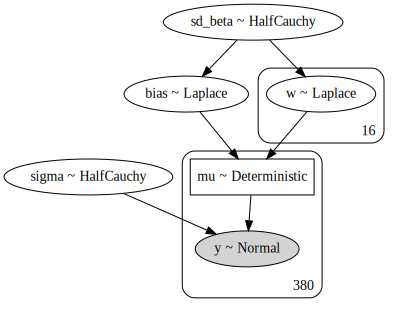

In [13]:
m_lasso_.show_model()

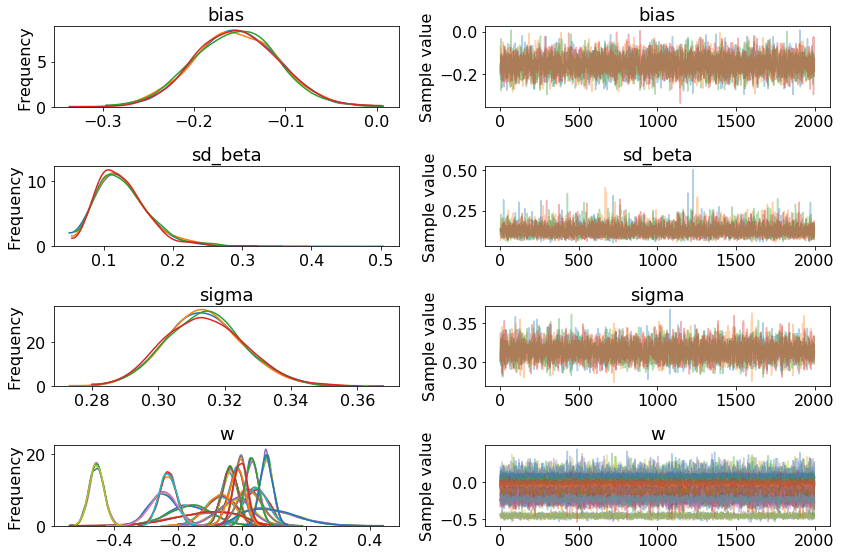

In [14]:
vars_ = ['bias', 'sd_beta', 'sigma', 'w',]
m_lasso_.evaluate_fit(show_feats=vars_);

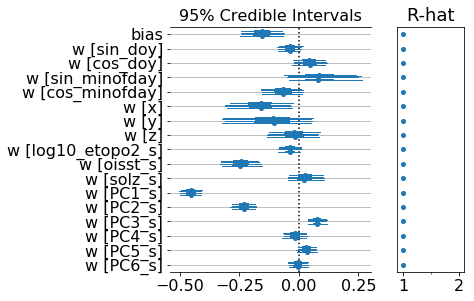

In [15]:
lbls = ds.loc[:, feat_beg: feat_end_ni].columns.tolist()
lbls_list = ['bias'] + ['w [%s]' % lbl for lbl in lbls]
m_lasso_.show_forest(['bias', 'w'], feat_labels=lbls_list);

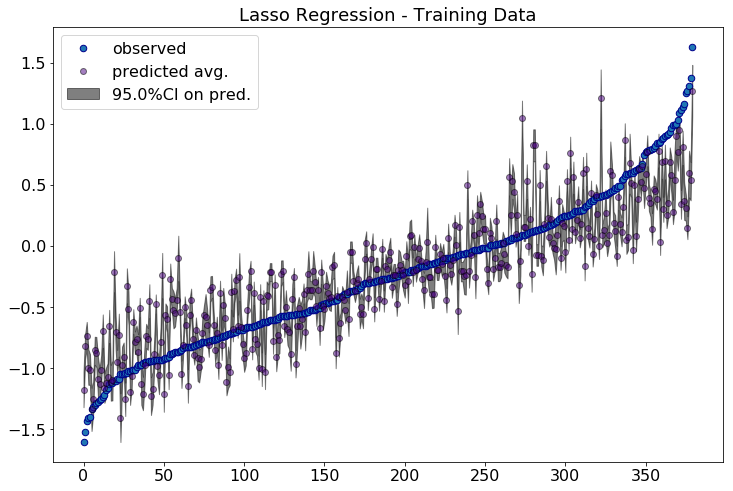

In [16]:
m_lasso_.plot_model_fits2(y_train, title = 'Lasso Regression - Training Data');

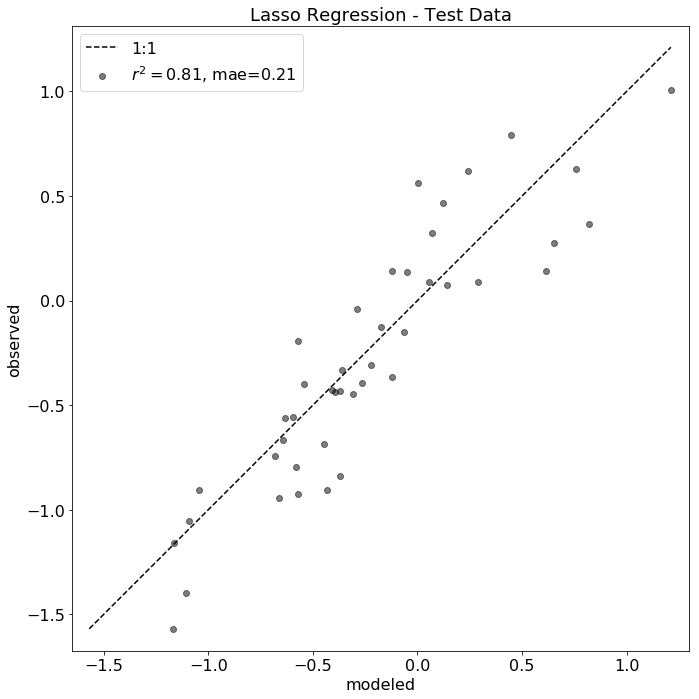

In [17]:
y_test_pred = m_lasso_.predict(X_s_test).values
m_lasso_.plot_model_fits(y_obs=y_test, y_pred=y_test_pred,
                         title='Lasso Regression - Test Data',
                         loss_metric='mae');

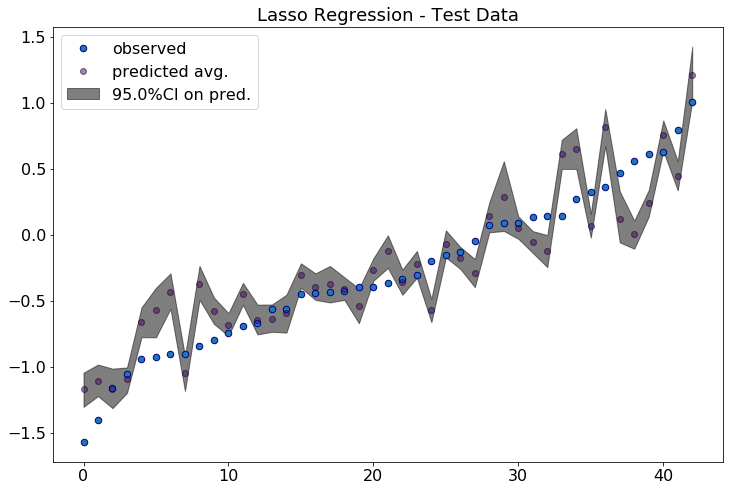

In [18]:
m_lasso_.plot_model_fits2(y_obs=y_test, y_pred=y_test_pred,
                         title='Lasso Regression - Test Data')

<u>Regularized Horseshoe</u>

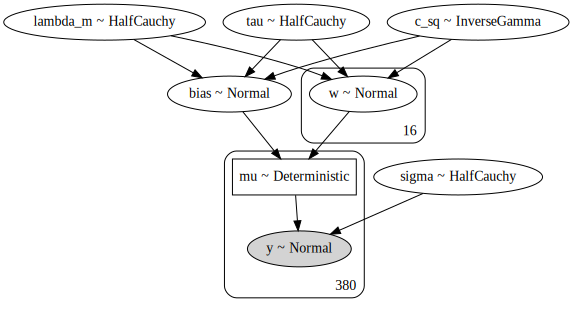

In [19]:
m_reg_horseshoe = PyMCModel(hs_regression, X_s_train, y_train,
                           model_name='reg_horseshoe', regularized=True)

m_reg_horseshoe.show_model()

In [20]:
m_reg_horseshoe.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bias, w, lambda_m, c_sq, tau]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:13<00:00, 721.82draws/s]
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.889584883302397, but should be close to 0.8. Try to increase the number of tuning steps.


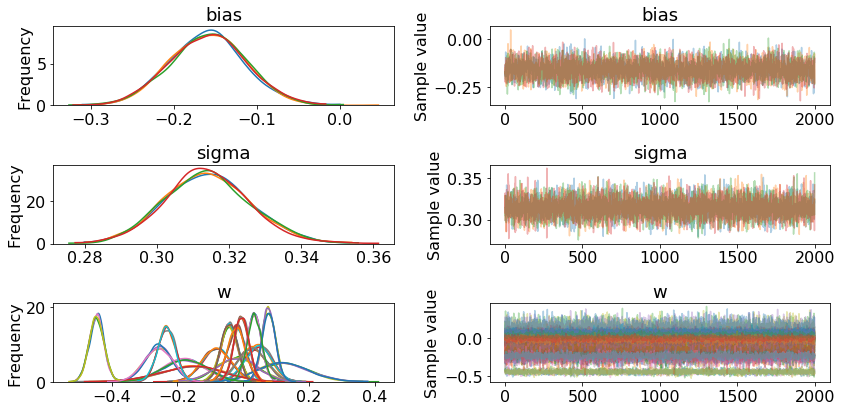

In [21]:
vars_ = ['bias', 'sigma', 'w',]
m_reg_horseshoe.evaluate_fit(show_feats=vars_);

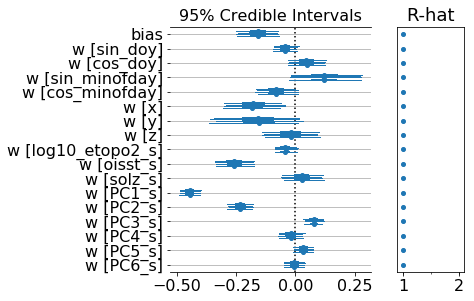

In [22]:
lbls = ds.loc[:, feat_beg: feat_end_ni].columns.tolist()
lbls_list = ['bias'] + ['w [%s]' % lbl for lbl in lbls]
m_reg_horseshoe.show_forest(['bias', 'w'], feat_labels=lbls_list);

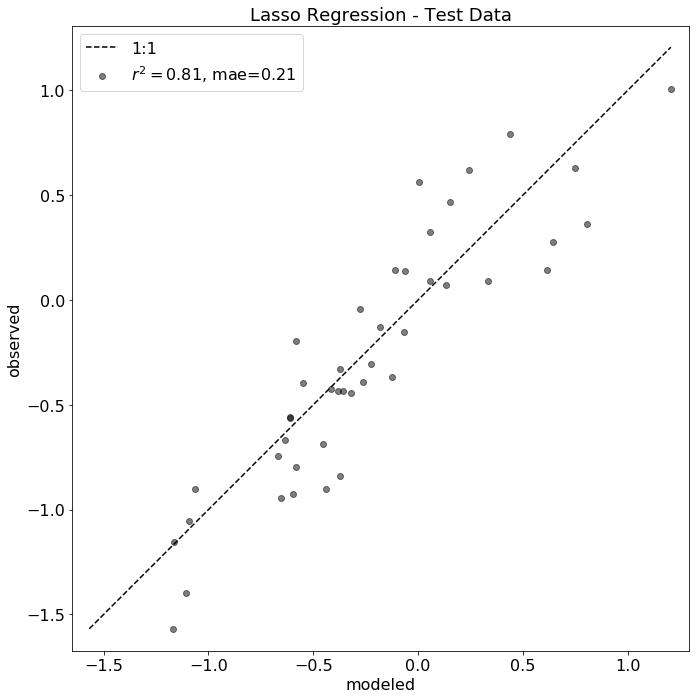

In [23]:
y_test_pred = m_reg_horseshoe.predict(X_s_test).values
m_reg_horseshoe.plot_model_fits(y_obs=y_test, y_pred=y_test_pred,
                                title='Lasso Regression - Test Data',
                                loss_metric='mae'
                               );

In [24]:
lasso_sub_feats = subset_significant_feature(m_lasso_.trace_, lbls_X_s,
                                             vars_=vars_, alpha=0.5,
                                             beg_feat=feat_beg)

In [25]:
lasso_sub_feats

['sin_doy',
 'cos_doy',
 'cos_minofday',
 'x',
 'y',
 'log10_etopo2_s',
 'oisst_s',
 'PC1_s',
 'PC2_s',
 'PC3_s',
 'PC5_s']

#### <u>3. Using Subset of "significant features</u>

In [26]:
X_sub = ds.dropna()[lasso_sub_feats]

In [27]:
X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y, 
                                                                   test_size=0.1,
                                                                   random_state=24)

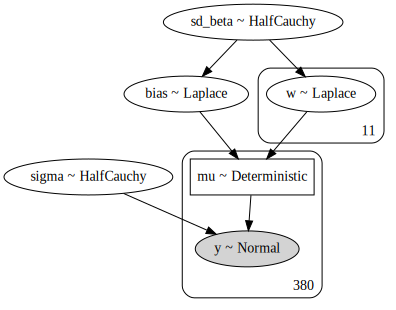

In [28]:
mlasso_sub = PyMCModel(lasso_regression, X_sub_train, y_sub_train,
                       model_name='lasso_regr_sub')
mlasso_sub.show_model()

In [29]:
mlasso_sub.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, bias, sigma, sd_beta]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:05<00:00, 1910.52draws/s]


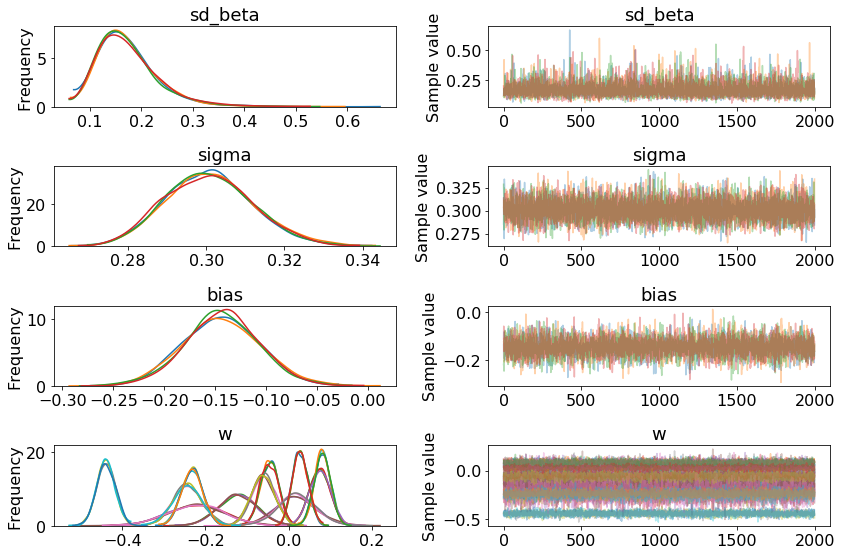

In [30]:
vars_ = ['sd_beta', 'sigma', 'bias', 'w']
mlasso_sub.evaluate_fit(vars_);

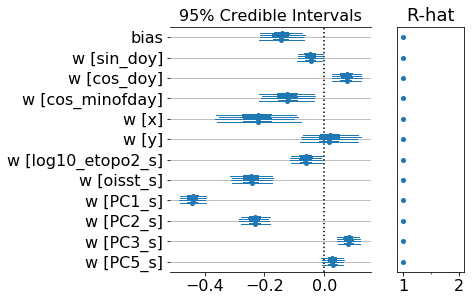

In [31]:

lbls_list = ['bias'] + ['w [%s]' % lbl for lbl in lasso_sub_feats]
mlasso_sub.show_forest(['bias', 'w'], feat_labels=lbls_list);

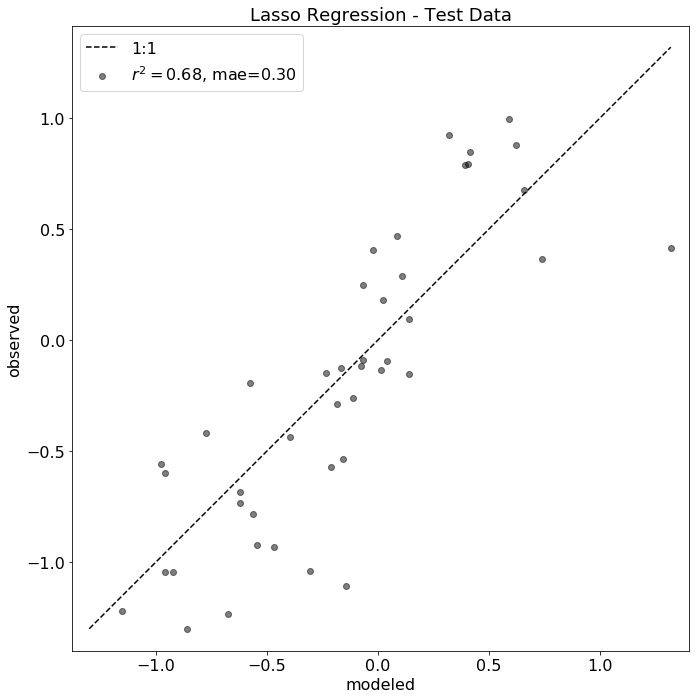

In [32]:
y_sub_test_pred = mlasso_sub.predict(X_sub_test).values
mlasso_sub.plot_model_fits(y_obs=y_sub_test, y_pred=y_sub_test_pred,
                                title='Lasso Regression - Test Data',
                                loss_metric='mae'
                               );

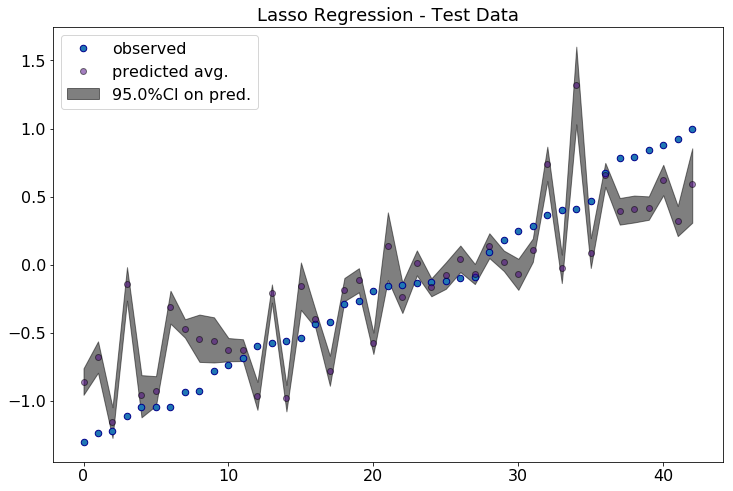

In [33]:
mlasso_sub.plot_model_fits2(y_obs=y_sub_test, y_pred=y_sub_test_pred,
                         title='Lasso Regression - Test Data');

### Modeling with Maximum Feature Interactions

#### <u>1. No missing value imputation</u>

In [34]:
mp_lasso = PyMCModel(lasso_regression, Xp_s_train, yp_train,
                     model_name='lasso_w_max_interactions')

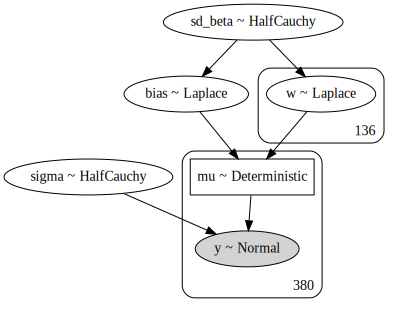

In [35]:
mp_lasso.show_model()

In [36]:
mp_lasso.fit_ADVI()

Average Loss = 113.71: 100%|██████████| 100000/100000 [00:47<00:00, 2091.33it/s]
Finished [100%]: Average Loss = 113.7


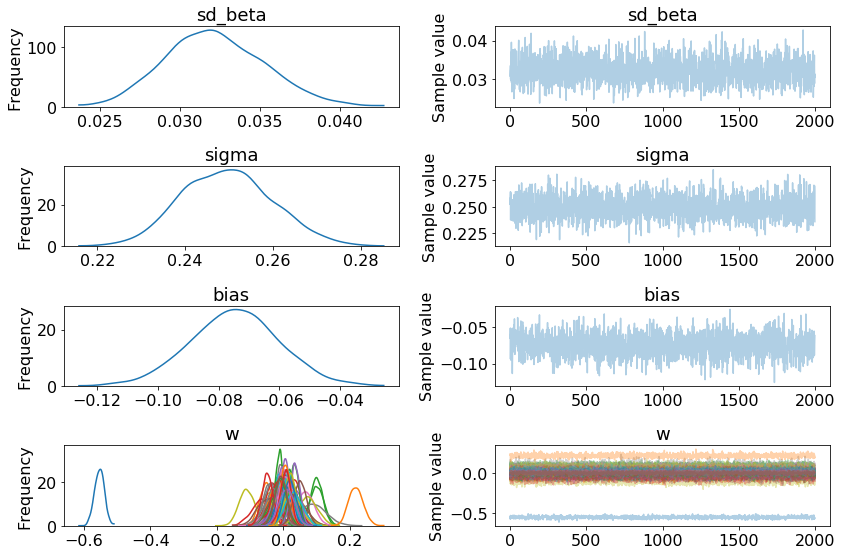

In [38]:
vars_ =['sd_beta', 'sigma', 'bias', 'w']
mp_lasso.evaluate_fit(vars_);

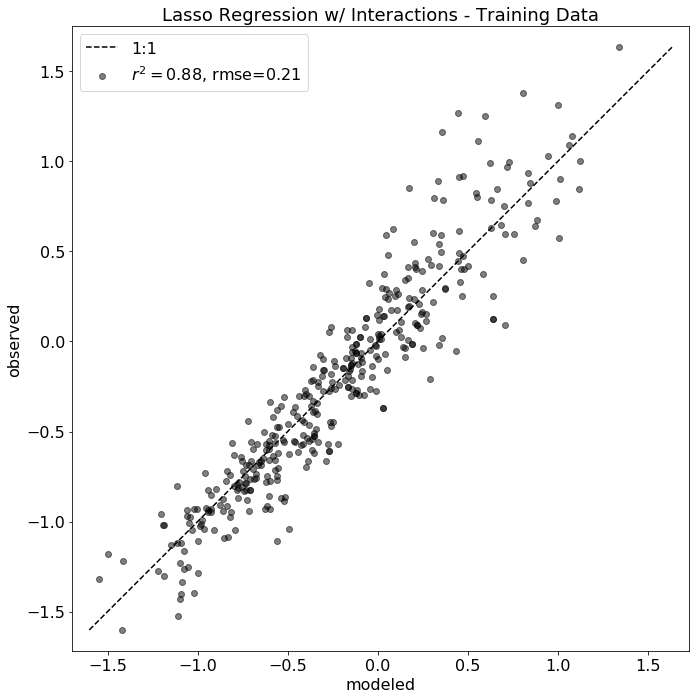

In [40]:
yp_train_pred = mp_lasso.predict(Xp_s_train)
mp_lasso.plot_model_fits(y_obs=yp_train, y_pred=yp_train_pred,
                         title='Lasso Regression w/ Interactions - Training Data');

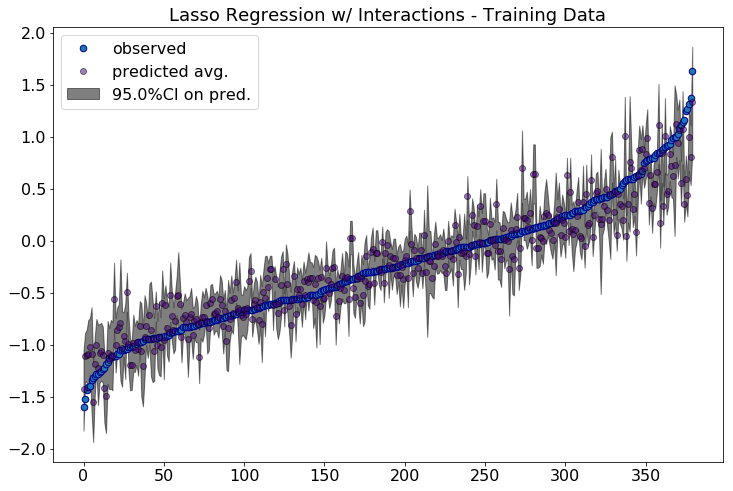

In [42]:
mp_lasso.plot_model_fits2(y_obs=yp_train, y_pred=yp_train_pred,
                         title='Lasso Regression w/ Interactions - Training Data');

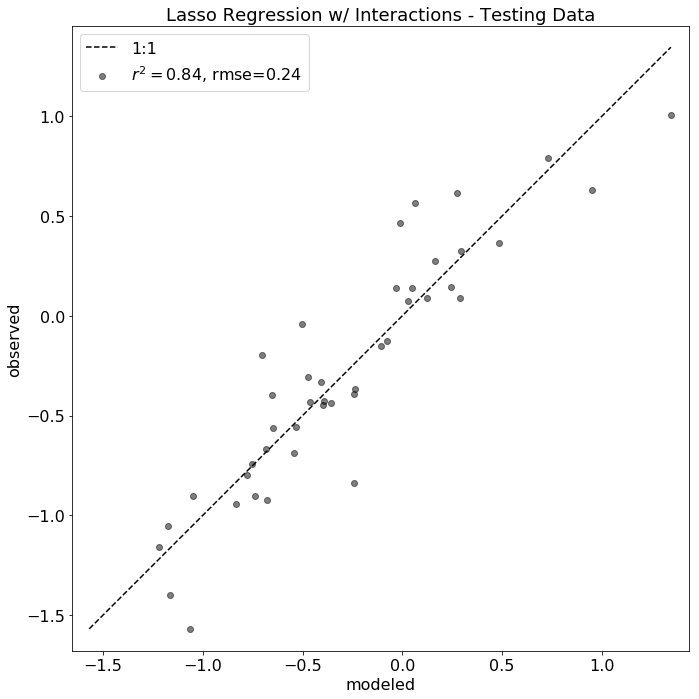

In [43]:
yp_test_pred = mp_lasso.predict(Xp_s_test)
mp_lasso.plot_model_fits(y_obs=yp_test, y_pred=yp_test_pred,
                         title='Lasso Regression w/ Interactions - Testing Data');

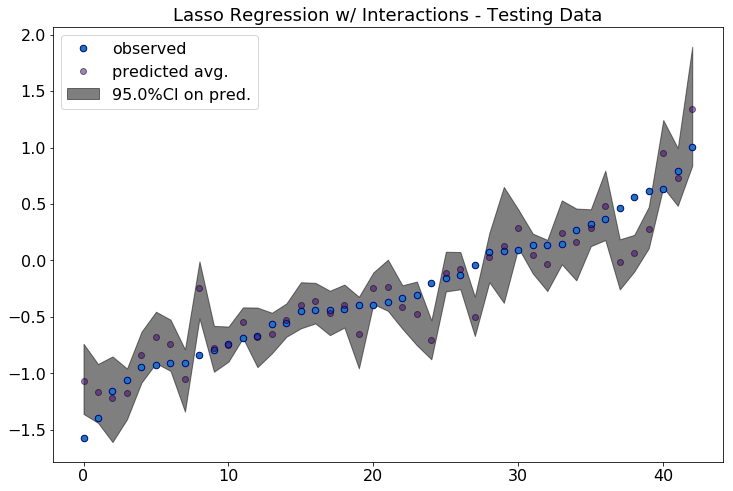

In [44]:
mp_lasso.plot_model_fits2(y_obs=yp_test, y_pred=yp_test_pred,
                         title='Lasso Regression w/ Interactions - Testing Data');

#### <u>2. Subset significant features </u>

In [47]:
vars_

['sd_beta', 'sigma', 'bias', 'w']

In [50]:
lasso_inter_sub_feats = subset_significant_feature(mp_lasso.trace_, lbls_Xp_s, feat_beg,
                                                   vars_=vars_, alpha=0.5)

In [51]:
lasso_inter_sub_feats

['cos_doy',
 'sin_minofday',
 'oisst_s',
 'PC1_s',
 'PC2_s',
 'PC3_s',
 'PC4_s',
 'PC6_s',
 'sin_doy cos_doy',
 'sin_doy cos_minofday',
 'sin_doy log10_etopo2_s',
 'sin_doy oisst_s',
 'sin_doy PC2_s',
 'sin_doy PC4_s',
 'sin_doy PC5_s',
 'cos_doy sin_minofday',
 'cos_doy cos_minofday',
 'cos_doy log10_etopo2_s',
 'cos_doy solz_s',
 'cos_doy PC3_s',
 'cos_doy PC5_s',
 'sin_minofday cos_minofday',
 'sin_minofday y',
 'sin_minofday log10_etopo2_s',
 'sin_minofday PC2_s',
 'sin_minofday PC4_s',
 'sin_minofday PC6_s',
 'cos_minofday y',
 'cos_minofday log10_etopo2_s',
 'cos_minofday solz_s',
 'cos_minofday PC1_s',
 'cos_minofday PC3_s',
 'cos_minofday PC4_s',
 'x PC1_s',
 'x PC3_s',
 'x PC4_s',
 'y oisst_s',
 'y PC2_s',
 'y PC3_s',
 'z oisst_s',
 'z PC2_s',
 'log10_etopo2_s PC1_s',
 'log10_etopo2_s PC2_s',
 'log10_etopo2_s PC4_s',
 'log10_etopo2_s PC6_s',
 'oisst_s solz_s',
 'oisst_s PC5_s',
 'solz_s PC2_s',
 'solz_s PC3_s',
 'solz_s PC4_s',
 'solz_s PC5_s',
 'PC1_s PC2_s',
 'PC1_s PC3_s',


In [54]:
Xp_s_sub = dps.dropna().loc[:, lasso_inter_sub_feats]

In [55]:
Xp_s_sub_train, Xp_s_sub_test, yp_sub_train, yp_sub_test = train_test_split(Xp_s_sub, y,
                                                                           test_size=0.1,
                                                                           random_state=22
                                                                           )

In [58]:
mp_lasso_sub = PyMCModel(lasso_regression, Xp_s_sub_train, yp_sub_train, 
                            model_name='lasso_regr_w_sub_inter.')

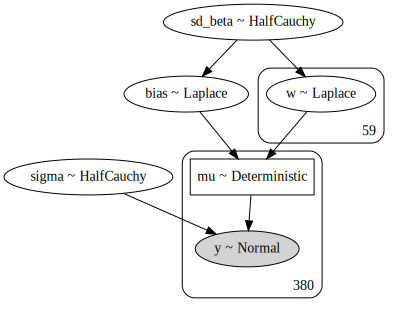

In [60]:
mp_lasso_sub.show_model()

In [61]:
mp_lasso_sub.fit_ADVI()

Average Loss = 43.687: 100%|██████████| 100000/100000 [00:44<00:00, 2248.78it/s]
Finished [100%]: Average Loss = 43.675


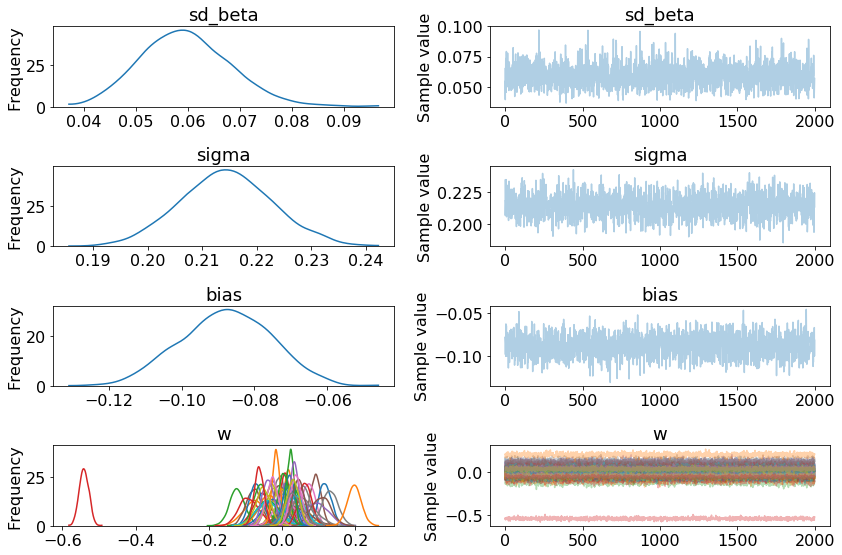

In [62]:
vars_ = ['sd_beta', 'sigma', 'bias', 'w']
mp_lasso_sub.evaluate_fit(vars_);

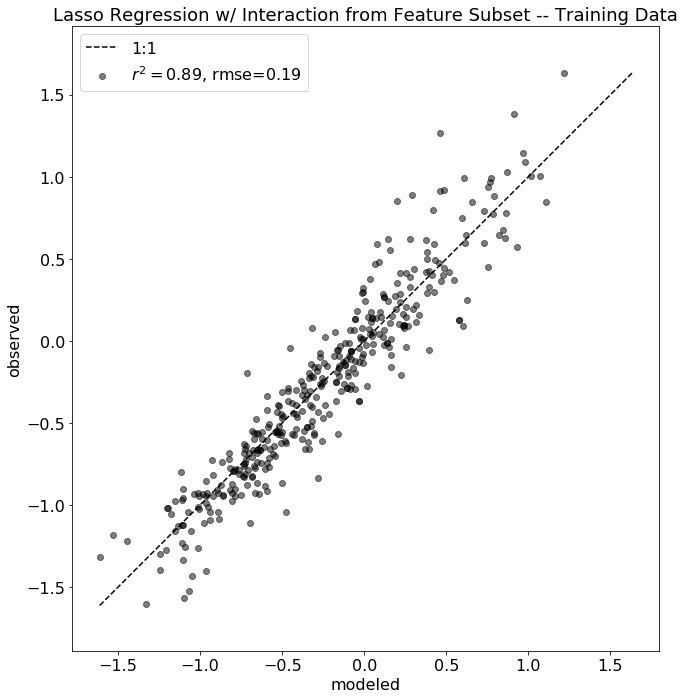

In [70]:
yp_sub_train_pred = mp_lasso_sub.predict(Xp_s_sub_train).values

ttl = 'Lasso Regression w/ Interaction from Feature Subset -- Training Data'
mp_lasso_sub.plot_model_fits(yp_sub_train, y_pred=yp_sub_train_pred, title=ttl);

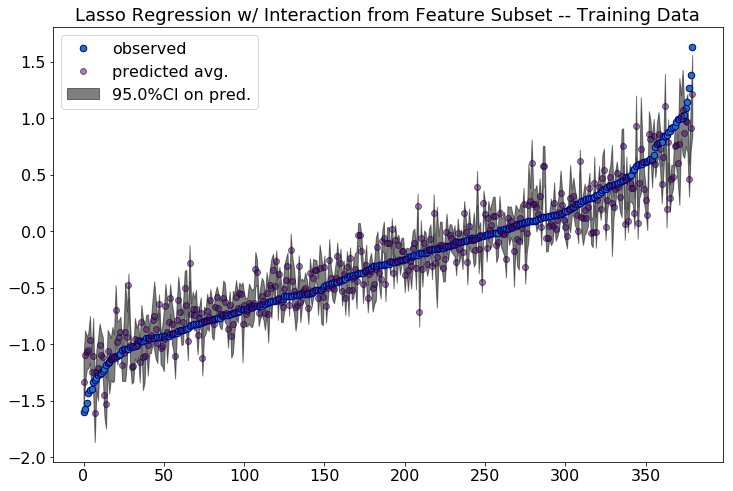

In [71]:
mp_lasso_sub.plot_model_fits2(yp_sub_train, y_pred=yp_sub_train_pred, title=ttl);

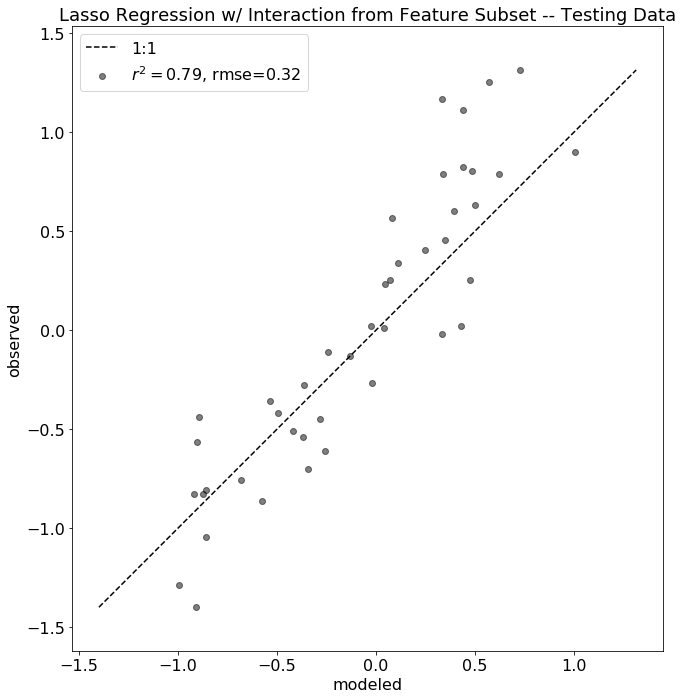

In [72]:
yp_sub_test_pred = mp_lasso_sub.predict(Xp_s_sub_test).values
ttl = 'Lasso Regression w/ Interaction from Feature Subset -- Testing Data'
mp_lasso_sub.plot_model_fits(yp_sub_test, y_pred=yp_sub_test_pred, title=ttl);

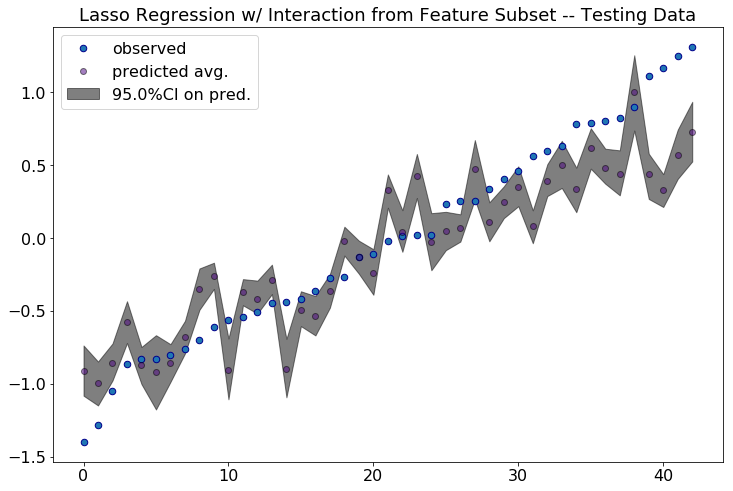

In [73]:
mp_lasso_sub.plot_model_fits2(yp_sub_test, y_pred=yp_sub_test_pred, title=ttl);

### Retraining All Models with the Full Data Set for Model Comparison

In [90]:
mod_dict = {m_lasso_.model: m_lasso_.trace_,
            m_reg_horseshoe.model: m_reg_horseshoe.trace_,
            mlasso_sub.model: mlasso_sub.trace_,
            mp_lasso.model: mp_lasso.trace_,
            mp_lasso_sub.model: mp_lasso_sub.trace_,
           }
pm.compare(mod_dict)

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
lasso_regr_w_sub_inter.,-12.49,66.2,0,0.74,36.1,0,1
lasso_w_interactions,159.77,105.66,172.26,0.24,38.36,52.03,1
lasso_regr_sub,178.27,13.62,190.76,0.02,32.63,45.96,1
reg_horseshoe,215.92,18.79,228.41,0,32.23,48.38,1
lasso_regr,216.86,18.56,229.35,0,32.21,48.39,1


In [91]:
pm.compare(mod_dict, ic='LOO')

,LOO,pLOO,dLOO,weight,SE,dSE,shape_warn
lasso_regr_w_sub_inter.,8.63,76.76,0,0.72,38.75,0,1
lasso_regr_sub,178.36,13.67,169.73,0.04,32.64,47.65,0
reg_horseshoe,216.2,18.92,207.57,0,32.27,50.61,0
lasso_regr,217.15,18.71,208.53,0,32.25,50.63,1
lasso_w_interactions,228.8,140.18,220.17,0.23,50.15,63.38,1


In [92]:
models_dict = {m_lasso_.model.name: m_lasso_,
            m_reg_horseshoe.model.name: m_reg_horseshoe,
            mlasso_sub.model.name: mlasso_sub,
            mp_lasso.model.name: mp_lasso,
            mp_lasso_sub.model.name: mp_lasso_sub,
           }
with open('./pickleJar/Models/pooled_models_from_train_test_split.pkl', 'wb') as f:
    pickle.dump(models_dict, f, protocol=pickle.HIGHEST_PROTOCOL)